# Table Of Contributions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline

d = {'Student Name' : ['Lucie Fontaine, Bogdan Capsa', 'Lucie Fontaine', 'Lucie Fontaine, Bogdan Capsa'], 
     'Student Number' : ['s212804, s210172', 's212804', 's212804, s210172']
     } 
  
ct = pd.DataFrame(d, index = ['Data Preprocessing', 'Latent space models of enzyme sequences', "Mapping enzyme sequences to their activity"]) 

ct

,Student Name,Student Number
Data Preprocessing,"Lucie Fontaine, Bogdan Capsa","s212804, s210172"
Latent space models of enzyme sequences,Lucie Fontaine,s212804
Mapping enzyme sequences to their activity,"Lucie Fontaine, Bogdan Capsa","s212804, s210172"


# Problem Statement

> In this notebook, we will fit 2748 enzyme sequences (column name: protein_amino_acid_sequence) to their experimental activity (column name: enzyme activity). Each sequence contains 96 letters (amino acids). '-' means gap. We will use VAE to predict enzymes activity, based on amino acid sequence information and then use the model to engineer new sequences with higher experimental activity.


For a thorough understanding of the problem, one needs to have master both domain knowdlegde and build relevant models. We're not biology specialists, but will offer what we consider to be relevant techniques, for tackling this issue.

Our approach will consist mainly of Bayesian lenses, as we will treat any hidden quantities as random variables and investigate them through their conditional distribution given observations. Hence, we will make reference to a general language of latent variables, which can be either parameters to the whole data set (see neural networks implementation) or local hidden structure to individual data points (latent space of VAE). 

The main probabilistic programming language used will be Pyro.



# Imports

In [ ]:
!pip install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 718 kB 4.8 MB/s 


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.optim import Adam, ClippedAdam
import seaborn as sns
import itertools
import scipy
from sklearn import linear_model

# random generator seed (for results reproducibility )
np.random.seed(42)

# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [ ]:
# matplotlib options
palette = itertools.cycle(sns.color_palette())
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

# Data Preprocessing

The dataset consists of 2748 enzyme sequences and their experimental activity, obtained from the recent publication [1]. 
These sequences come from the same family, which means that they are descended from a common ancestor, and were aligned so that each of them contains 96 positions. The alignment, called multiple sequence alignment (MSA), shows mutation events, such as point mutations (a single amino acid change) that appear as differing characters in a single position, and insertion or deletion mutation that appear as hyphens [2].

In [ ]:
df = pd.read_csv('https://gitlab.gbar.dtu.dk/s210172/enzyme-activity/raw/main/enzyme_data.csv')
df.rename(columns = {'protein_amino_acid_sequence':'sequence'}, inplace = True)
df.drop(['Unnamed: 0'], axis = 1, inplace = True) 
df.head()

,sequence,enzyme_activity
0,-TSENPLLALREKISALDEKLLALLAERRELAVEVGKAKLLSHRPV...,1.00
1,---DERIQALRKEVDRVNREILRLLSERGRLVQEIGRLQTELGLPH...,-0.06
2,PEDCTGLADIREAIDQIDLDIVQALGRRMDYVKAASRFKANEA-AI...,0.04
3,-TPENPLLDLRVKISALDEKLLALLAERRALAIEVGKAKLDSHRPV...,0.65
4,---DERIQALRREVDRVNRELLRLLSERGRLVQEIGRIQTELGLPH...,-0.08


In latent space models, a protein sequence is represented as a $21 \times L$ binary matrix $\mathbf{X}$ where $L$ is the number of positions in the sequence and 21 is the number of unique characters (an amino acid or a gap), and $X_{ij} = 1$ if the character number $i$ is at the $j$th position in the sequence. 

In [ ]:
# One Hot Encoding of sequences

# First, we count the number of unique amino acids 
sequences = df.groupby('sequence')['sequence'].apply(list).tolist()
all_letters = []
for seq in sequences:
    seq = ''.join(str(e) for e in seq)
    letters = [char for char in seq] 
    for letter in letters:
        all_letters.append(letter)

letters = np.unique(all_letters) # 21 unique amino acids
dic = dict(zip(letters, np.arange(len(letters)))) # Amino acid types are labeled using numbers from 0 to 20

N = len(df) # number of sequences in the dataset
L = 96 # number of positions in each sequence
X = np.zeros((N, len(letters), L))
for n in range(N):
    for l in range(L):
        X[n, dic[df.iloc[n, 0][l]], l] = 1 

X = X.reshape(N, len(letters)*L) 
y = np.array(df['enzyme_activity'])

# Latent space models of enzyme sequences

In latent space models, the sequences $\mathbf{X}$ are encoded by latent variables $\mathbf{Z}$, and their joint distribution is $p_{\boldsymbol\theta}(\mathbf{X}, \mathbf{Z}) = p_\theta(\mathbf{Z}) p_{\boldsymbol\theta}(\mathbf{X}|\mathbf{Z})$, where $\boldsymbol\theta$ are parameters of the joint distribution. This implies that in the generative process of $\mathbf{X}$ and $\mathbf{Z}$, $\mathbf{Z}$ is first sampled from the prior distribution $p_\theta(\mathbf{Z})$ and then $\mathbf{X}$ is sampled from the conditional distribution $p_{\boldsymbol\theta}(\mathbf{X}|\mathbf{Z})$. 

Learning the parameters $\boldsymbol\theta$ given $\mathbf{X}$ using maximum likelihood is challenging because the marginal distribution $p_{\boldsymbol\theta}(\mathbf{X})$ and the posterior distribution $p_{\boldsymbol\theta}(\mathbf{Z}|{\mathbf{X}})$ are analytically intractable [3]. Therefore, an approximation method, called stochastic variational inference (SVI), was used. SVI introduces a family of distributions, $q_{\boldsymbol\phi}(\mathbf{Z}|\mathbf{X})$, parameterized by $\boldsymbol\phi$, to approximate $p_{\boldsymbol\theta}(\mathbf{Z}|{\mathbf{X}})$ and an alternative objective function to $p_{\boldsymbol\theta}(\mathbf{X})$, called the evidence lower bound objective function (ELBO), which is a lower bound of $\log p_{\boldsymbol\theta}(\mathbf{X})$. 

In this project, a variational auto-encoder (VAE), which enables SVI to learn latent space models, is used to learn the latent space of the family of enzymes in the dataset. The trained latent space model provides a sequence encoder and decoder, which are both  fully connected artificial neural networks (ANN) with one hidden layer.

## Decoder

The decoder model transforms each point in the latent space $\mathbf{Z}$ into a distribution $p_{\boldsymbol\theta}(\mathbf{X}|\mathbf{Z})$ of $\mathbf{X}$ in the protein sequence space

The corresponding ANN has `z_dim` inputs (which is the number of dimensions of the latent space), a hidden layer, and 2016 outputs (which is the number of dimensions of the one-hot encoded sequences). The ANN has a Tanh activation function [3] in the hidden layer, and Sigmoid in the final layer, which outputs the probability of one character being at a given position in the sequence. 

In [ ]:
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 2016)
        # setup the non-linearities
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.tanh(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 2016
        p = self.sigmoid(self.fc21(hidden))
        return p

## Encoder

The encoder model transforms each enzyme sequence $\mathbf{X}$ into a distribution $q_{\boldsymbol\phi}(\mathbf{Z}|\mathbf{X})$ of $\mathbf{Z}$ in the latent space. 
It is chosen to be a multidimensional Gaussian distribution with mean and covariance parametrized using an ANN with one hidden layer. The same Tanh activation function is used for the hidden layer and an exponential is applied to the output of the covariance ANN to ensure it is positive. 

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(2016, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.tanh = nn.Tanh()
 
    def forward(self, x):
        # define the forward computation on the sequence x
        x = x.float()
        # compute the hidden units
        hidden = self.tanh(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale

## VAE

As mentioned previously, VAE enables SVI to learn the latent space model. SVI takes as input a model and a guide, which we will implement in the VAE class. 

The model follows the generative process of $\mathbf{X}$ and $\mathbf{Z}$, which is the following:

For each observation $n=1,...,N$:
- Draw hidden variable $\mathbf{Z_n} \sim \mathcal{N}(\mathbf{Z_n}|\mathbf{0}, \mathbf{I})$
- Draw sequence $\mathbf{X_n} \sim \text{Bernoulli}(p_{\boldsymbol\theta}(\mathbf{X_n}|\mathbf{Z_n}))$

Sequences are sampled from a Bernoulli distribution because they are represented as one-hot encoded matrices.

The guide is the variational distribution $q_{\boldsymbol\phi}(\mathbf{Z}|\mathbf{X})$ returned by the encoder model.

Both the model and guide make use of the encoder and decoder models. We choose by default two dimensions for the latent space for visualization purposes and 100 neurons in the hidden layer of the ANNs in the encoder and decoder models. 

Finally, the methods `forward` and `backward` are created to respectively encode a sequence in the latent space and decode the latent space representation of a sequence.

In [ ]:
class VAE(nn.Module):
    # by default our latent space is 2-dimensional
    # and we use 100 hidden units
    def __init__(self, z_dim=2, hidden_dim=100, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
 
        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
 
    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            # setup hyperparameters for prior p(z) 
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            # decode the latent code z
            p = self.decoder(z)
            # score against actual sequences
            pyro.sample("obs", dist.Bernoulli(p).to_event(1), obs=x)
 
    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    # encode a sequence
    def forward(self, x):
        # encode sequence x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()        
        return z_loc, z_scale

    # decode a latent space representation of a sequence
    def backward(self, z):
        # decode the sequence
        p = self.decoder(z)
        # sample in sequence space
        x = dist.Bernoulli(p).sample()
        return x

# Mapping enzyme sequences to their activity


<!-- After we  declared the probabilistic model, the next step would be to perform inference. Inference plays an important role, as it allows answering questions about the modeled data, by computing the posterior distribution of latent variables, given the observed ones.  -->

Learning the latent space of the family of enzyme sequences in the dataset using VAE will enable us to map the sequences to their activity, in order to both predict the activity of a new sequence and engineer new sequences with higher activity. 

## Training the latent space model using VAE

We will split the dataset in a training set and a test set. The latent space model will be trained on the training set and evaluated on the test set. 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Functions

In order to train and evaluate the model, we need to setup data loaders which require a class for the dataset.

In [ ]:
from torch.utils.data import Dataset

class MSA_Dataset(Dataset):
    '''
    Dataset class for multiple sequence alignment.
    '''
    
    def __init__(self, seq_msa_binary):
        '''
        seq_msa_binary: a two dimensional np.array. 
                        size: [num_of_sequences, length_of_msa*num_amino_acid_types]
        '''
        super(MSA_Dataset).__init__()
        self.seq_msa_binary = seq_msa_binary
        
    def __len__(self):       
        return self.seq_msa_binary.shape[0]
    
    def __getitem__(self, idx):
        return self.seq_msa_binary[idx, :]

Then we will set up the train and test data loaders, opting for a random split, as this will improve the performance. We won't use mini-batches because the dataset is quite small. 

In [ ]:
def setup_data_loaders(X_train, X_test, use_cuda=False):
    train_set = MSA_Dataset(X_train)
    test_set = MSA_Dataset(X_test)
    N_train = len(X_train)
    N_test = len(X_test)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=N_train, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=N_test, shuffle=False, **kwargs)
    print("train_loader", train_loader)
    print("test_loader", test_loader)
    return train_loader, test_loader

Finally, we implement functions to train and evaluate the model.

In [ ]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over the entire train set (no mini-batch)
    for x in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)
 
    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [ ]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for x in test_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

### Training and evaluation

To effectively learn the latent space of the sequences, the learning rate of the optimizer and number of epochs of the training were tuned, so that the training and test loss decrease rapidly enough and are nearly converged in the end, within reasonable computing time. We use CUDA to make the training faster.

In [ ]:
import os
smoke_test = 'CI' in os.environ

# Run options
LEARNING_RATE = 0.005
USE_CUDA = True
 
# Run only for a single iteration for testing
NUM_EPOCHS = 1 if smoke_test else 1000
TEST_FREQUENCY = 5

In [ ]:
train_loader, test_loader = setup_data_loaders(X_train, X_test, use_cuda=USE_CUDA)
 
# clear param store
pyro.clear_param_store()
 
# setup the VAE
vae = VAE(use_cuda=USE_CUDA)
 
# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)
 
# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
 
train_elbo = []
test_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
 
    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

train_loader <torch.utils.data.dataloader.DataLoader object at 0x7fc290fa7690>
test_loader <torch.utils.data.dataloader.DataLoader object at 0x7fc290fa7450>
[epoch 000]  average training loss: 1415.5979
[epoch 000] average test loss: 1263.4736
[epoch 001]  average training loss: 1262.8428
[epoch 002]  average training loss: 1130.6010
[epoch 003]  average training loss: 992.6130
[epoch 004]  average training loss: 882.4146
[epoch 005]  average training loss: 769.9558
[epoch 005] average test loss: 669.6181
[epoch 006]  average training loss: 669.4136
[epoch 007]  average training loss: 587.2166
[epoch 008]  average training loss: 516.1515
[epoch 009]  average training loss: 456.6003
[epoch 010]  average training loss: 409.7970
[epoch 010] average test loss: 374.9720
[epoch 011]  average training loss: 374.4576
[epoch 012]  average training loss: 349.0569
[epoch 013]  average training loss: 331.5528
[epoch 014]  average training loss: 319.9979
[epoch 015]  average training loss: 312.5416

## Encoding of the sequences in the latent space

We encode the 2748 sequences in the two-dimensional latent space to visualize their latent space reprensentation. One can see below a star shape depicting the latent space, which is representative for the enzymes, as they belog to the same family.

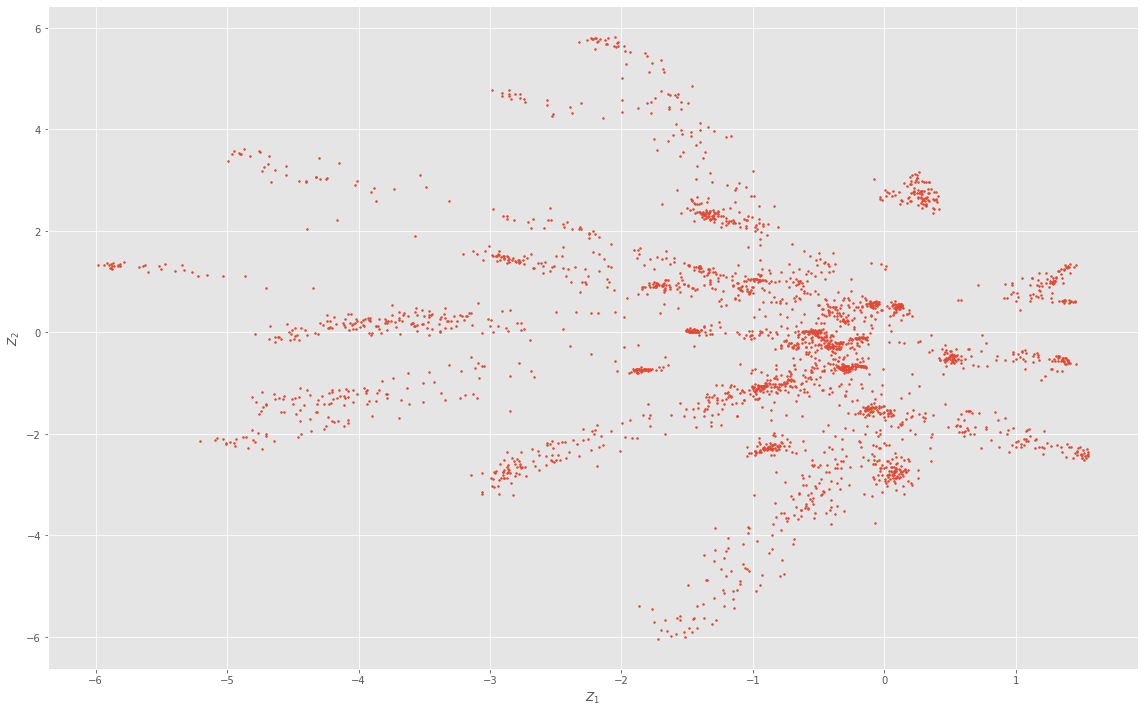

In [ ]:
# load all the sequences
train_data = MSA_Dataset(X)
train_data_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=N)

# encode the sequences in the latent space 
for data in train_data_loader:
    z_loc, _ = vae.forward(data.cuda())

z_loc = z_loc.cpu().data.numpy()

# visualize the latent space reprensentation of the sequences
plt.figure(0)
plt.clf()
plt.plot(z_loc[:,0], z_loc[:,1], '.', markersize = 3)
plt.xlabel("$Z_1$")
plt.ylabel("$Z_2$")
plt.tight_layout()

The latent space representation of the 2748 sequences has a star structure similar to those observed for other protein families in the publication [3], which captures the ancestral relationship between sequences of the same family.

We can also color the points according to their experimental activity, to visualize the mapping between the latent space of the family and the activity. This can guide us in designing new sequences with higher activity by selecting a point from the unexplored latent space and converting it into a sequence using the decoder.

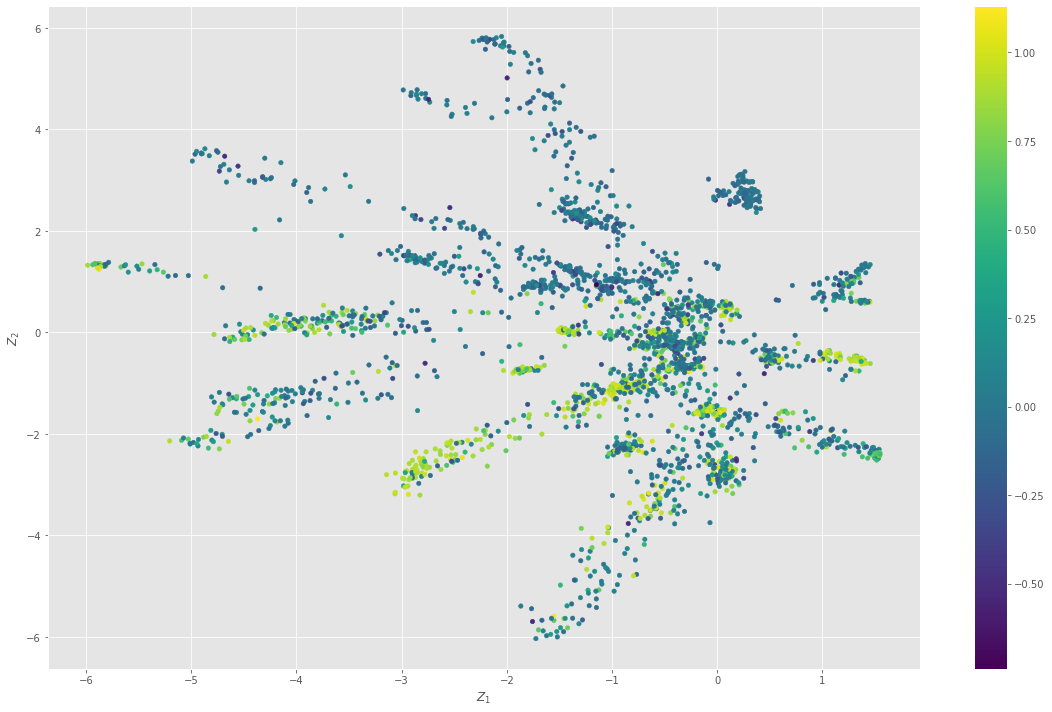

In [ ]:
plt.figure(0)
plt.clf()
plt.scatter(z_loc[:,0], z_loc[:,1], c = y, s = 20)
plt.xlabel("$Z_1$")
plt.ylabel("$Z_2$")
plt.tight_layout()
plt.colorbar()

The colored visualization of the latent space shows that the lower branches of the star structure have higher activity and that the highest activities are located at the tip of the branches. 

The interactive visualization below enables us to know more precisely which region of the latent space has the highest experimental activity. 

In [ ]:
# interactive visualization
import plotly.express as px
fig = px.scatter(x=z_loc[:,0], y=z_loc[:,1], color=y)
fig.show()

According to the interactive visualization, the upper middle branch of the star structure has the highest activities, with activities greater than 1 at the tip of the branch. In order to design new sequences with higher activities than those experimentally observed in the dataset, we can therefore search a sequence in this direction of the latent space, for example z = [-3.15, -3.2]. We will do this in a later section.

Please note, that there is an element of stochasticity, so if you re-run the notebook, you might end up having different values for the latent space.

## Predicting enzyme activity

In order to predict the activity of a new sequence, we will fit the experimental activity to the latent space representation of the sequences of our dataset, obtained previously by training a latent space model using VAE. We will then compute the error between the predicted and true values for the train and test set to evaluate the adequacy of our fit. 

First, we need to get the latent space representation of the sequences of the train and test sets.

<!-- Our aim is: given the latent space, use an inference algorithm
to approximate the posterior (the conditional distribution of the hidden variables given the data), which points to the particular hidden pattens that our data exhibits. Finally, we use the posterior to
test the model against the data, identifying its effectiveness.

For this purpose, we will use both a Linear Regression Model and a Neural Network, and compare their results with the real values of the enzyme activity. -->

In [ ]:
train_loader, test_loader = setup_data_loaders(X_train, X_test, use_cuda=False)

# getting the latent space representation of the train set
for data in train_loader:
  data = data.cuda()
  z_loc_train_torch, _ = vae.forward(data)

# getting the latent space representation of the test set
for data in test_loader:
  data = data.cuda()
  z_loc_test_torch, _ = vae.forward(data)  

# converting to numpy and switching to cpu
z_loc_train = z_loc_train_torch.cpu().data.numpy() 
z_loc_test = z_loc_test_torch.cpu().data.numpy()
# switching torch tensors to cpu 
z_loc_train_torch = z_loc_train_torch.cpu()
z_loc_test_torch = z_loc_test_torch.cpu() 

train_loader <torch.utils.data.dataloader.DataLoader object at 0x7f25829e7110>
test_loader <torch.utils.data.dataloader.DataLoader object at 0x7f2582c71e10>


Then, we define a function that computes different error measures: the Pearson and Spearman correlations, the MAE, RAE, RMSE and R2. Correlations should be as close to 1 as possible, or at least more than 0.5. MAE, the mean absolute error, and RMSE, the root mean squared error, measure the difference between the predicted and true values. RAE, the relative absolute error, is a ratio between this difference and the error of a naive model which always predicts the mean of the true values, and should be as small as possible, and less than 1. R2, the coefficient of determination, can be seen as the opposite of RAE, because it is equal to 1 minus the RAE in which the absolute difference is replaced by the square difference. It represents the fraction of variance of the actual value of the response variable captured by the regression model and should be as high as possible, and is less than 1.

We will mainly look at the correlation, RAE and R2, because MAE and RMSE are absolute differences.

In [ ]:
def compute_error(trues, predicted, title):
    pearson = np.corrcoef(predicted, trues)[0,1]
    spearman, _ = scipy.stats.spearmanr(trues, predicted)
    mae = np.mean(np.abs(predicted - trues))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))    
    r2 = 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2)

    print(f"{title}")
    print(f" PearsonCorr: {pearson}\n SpearmanCorr:{spearman}\n MAE:{mae}\n RMSE:{rmse}\n RAE:{rae}\n R2:{r2}")

### KNN Baseline

We will take KNN as a baseline, for learning taxonomy relationships.

We will fit a KNN, with k=1, on the one-hot encoded matrix.
We must specify from the very beginning, that domain experts confirmed us, that it can be a very hard problem to beat KNN, especially with such a small amount of data.

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
# y_pred_knn = y_pred_knn.mean(axis=0).detach().numpy()

compute_error(y_test, y_pred_knn, "KNN Test results")

KNN Test results
 PearsonCorr: 0.43972576311423084
 SpearmanCorr:0.3973924056250494
 MAE:0.3293605292171996
 RMSE:0.46273466885424436
 RAE:0.8945556950728077
 R2:-0.21689256699803394


With a RAE less than 1, KNN performs better than the naive model.

Text(0, 0.5, 'Experimental activity')

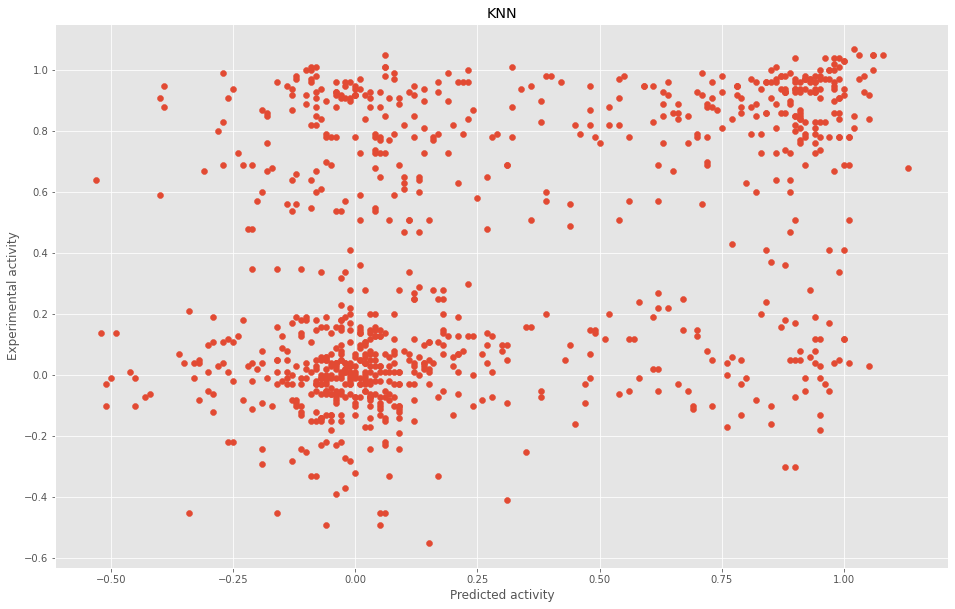

In [ ]:
plt.scatter(y_test, y_pred_knn)
plt.title('KNN')
plt.xlabel('Predicted activity')
plt.ylabel('Experimental activity')

### Linear Regression

We will first start with a simple linear regression model. 

In [ ]:
def model_linear(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))                   # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(X.shape[1]), 
                                            torch.ones(X.shape[1])).to_event())    # Priors for the regression coefficients
    sigma = pyro.sample("sigma", dist.HalfCauchy(5.))                   # Prior for the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

We first run sklearn's linear regression for the sake of comparison.

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(z_loc_train, y_train)
y_hat = regr.predict(z_loc_test)

compute_error(y_test, y_hat, "Test LR")

Test LR
 PearsonCorr: -0.14586025984088488
 SpearmanCorr:-0.1666050957907172
 MAE:0.36941556528227065
 RMSE:0.4211388441213548
 RAE:1.0033466929301336
 R2:-0.007949473670102902


For various models, it may be infeasible to evaluate the posterior distribution exactly or to compute expectations with respect to it. 

We have decided to use MCMC (Marchov Chain Monte carlo), a stochastic technique for approximate inference, that relies on sampling and has the property that given infinite computational resources, can generate exact results. With this method, we'll iteratively construct a Markov chain of samples, that will converge at some point, the sample draws being close to the true posterior distribution and can be collected to approximate the required expectations.


<!-- The evidence lower bound, L(q), can then beoptimized by using a coordinate ascent algorithm that iteratively optimizes the variational parameters of the approximate posterior distribution of each latent variable q(zm) in turn, holding the others fixed, until a convergence criterium is met. Thisensures convergence to a local maximum of L(q). -->


In [ ]:
# Prepare data for Pyro model
y_train_torch = torch.tensor(y_train).float()

In [ ]:
# Run inference in Pyro
nuts_kernel = NUTS(model_linear)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(z_loc_train_torch, y_train_torch)

# Show summary of inference results
mcmc.summary()

Sample: 100%|██████████| 1200/1200 [00:19, 60.42it/s, step size=3.67e-01, acc. prob=0.920]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.27      0.01      0.27      0.25      0.29    723.49      1.00
   beta[0]      0.01      0.01      0.01     -0.00      0.02    808.05      1.00
   beta[1]     -0.00      0.01     -0.00     -0.01      0.01    965.71      1.00
     sigma      0.42      0.01      0.42      0.41      0.43    557.88      1.00

Number of divergences: 0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



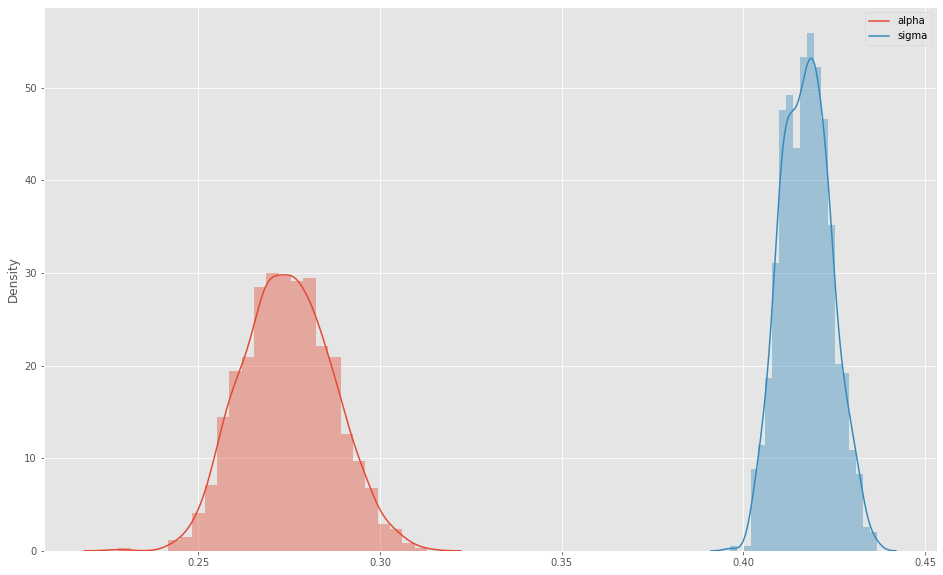

In [ ]:
# Extract samples from posterior
posterior_samples = mcmc.get_samples()

sns.distplot(posterior_samples["alpha"])
sns.distplot(posterior_samples["sigma"])

plt.legend(["alpha", "sigma"])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



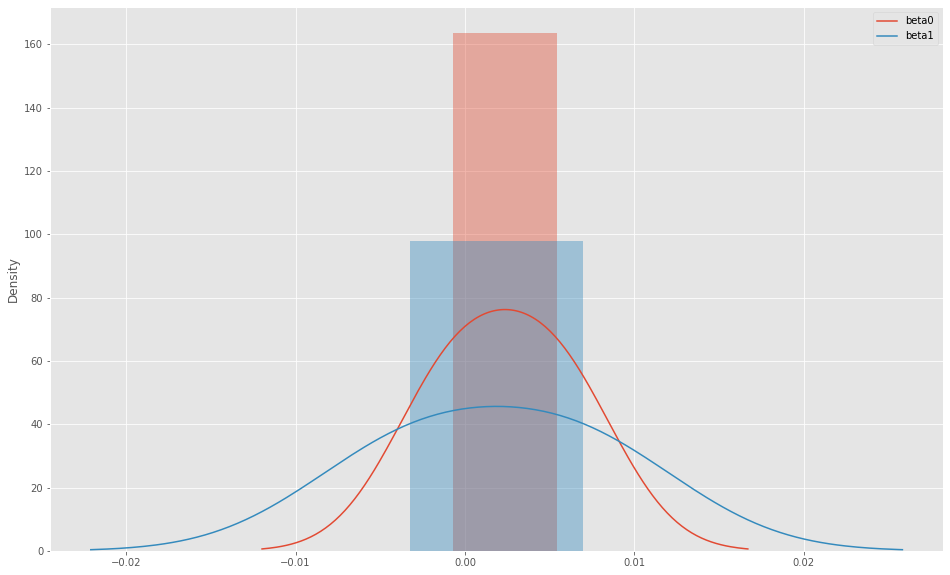

In [ ]:
for i in range(2):
    sns.distplot(posterior_samples["beta"][i])

    # Alternative to avoid warnings
    #sns.histplot(posterior_samples["beta"][:,i], kde=True, color=next(palette), stat='density', element='step')

plt.legend(["beta%d" % i for i in range(2)])
plt.show()

In [ ]:
print(posterior_samples["alpha"].shape)
print(posterior_samples["beta"].shape)

beta_hat=torch.mean(posterior_samples["beta"], axis=0)
alpha_hat=torch.mean(posterior_samples["alpha"], axis=0)

y_hat = alpha_hat+np.dot(z_loc_test,beta_hat)

torch.Size([1000])
torch.Size([1000, 2])


In [ ]:
y_hat_train = alpha_hat+np.dot(z_loc_train,beta_hat)
compute_error(y_train, y_hat_train.numpy(), "Train Linear Regression Results")

Train Linear Regression Results
 PearsonCorr: 0.026161061875836784
 SpearmanCorr:0.024697935604266842
 MAE:0.36804307555776783
 RMSE:0.41658675998727446
 RAE:0.999290069988284
 R2:0.0006813857737105744


In [ ]:
compute_error(y_test, y_hat.numpy(), "Test Linear Regression Results")

Test Linear Regression Results
 PearsonCorr: -0.1523100561778828
 SpearmanCorr:-0.17427656107337539
 MAE:0.3693007664407101
 RMSE:0.42110295897858174
 RAE:1.0030348949203665
 R2:-0.007777706708971266


For both the train and test set, the correlations are low, RAE close to 1 and R2 close to 0, so linear regression is not fitting the data well. The plot below shows that the predicted and true values of the test set are not correlated. The reason might be that the activity doesn’t depend linearly on the latent  variable. Therefore, we will use an ANN.

Text(0, 0.5, 'Experimental activity')

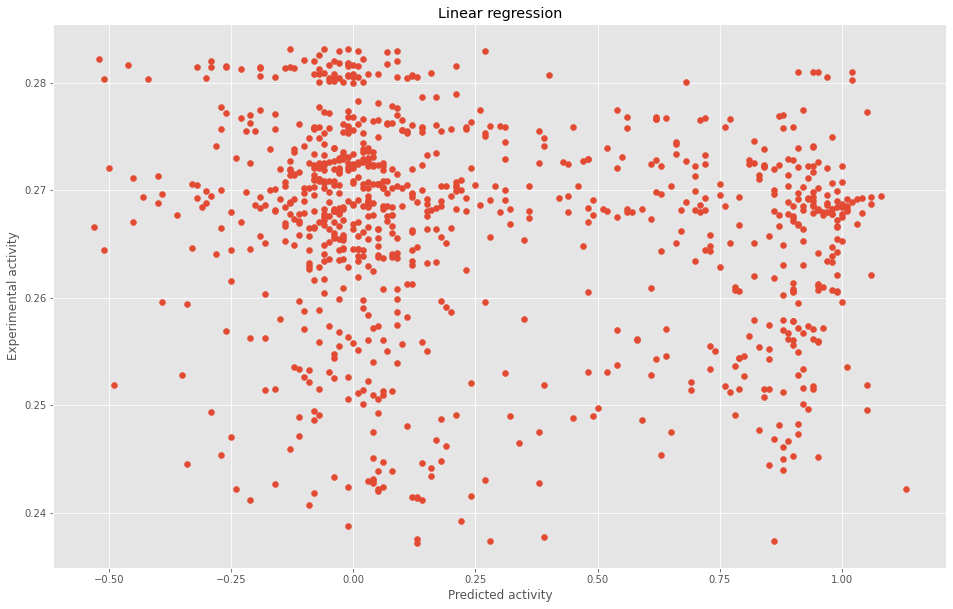

In [ ]:
plt.scatter(y_test, y_hat.numpy())
plt.title('Linear regression')
plt.xlabel('Predicted activity')
plt.ylabel('Experimental activity')

### NN

As we are building a latent variable model, we'll think on what kinds of hidden quantities might be used, to describe the type of data we are interested in and we encode that relationship in a joint probability distribution of hidden and observed random variables. Then, given an observed data set, we uncover
the particular hidden quantities that describe it through the conditional distribution of the hidden variables given the observations, ie the posterior. Further, we use the posterior to form the predictive distribution, the distribution over future data that both observations and the model imply.

This section will try to capture the enzyme activity, through non-linearity, as it is not expected that the relationship between the sequence latent space representation and the activity is linear.

The first thing we need to do is to define the neural network as a PyTorch class extending torch.nn.Module, as Pyro is supported by PyTorch on the backend. We have tried different architectures for the number of hidden layers, and the best one found so far has only 1, with 100 neurons.

We have chosen to use tanh as an activation function, since it resembles the logistic sigmoid but is better, as the negative inputs will be mapped strongly negative and the zero inputs will be mapped near zero in the tanh graph.

In [ ]:
class FFNN(torch.nn.Module):
    def __init__(self, n_in, n_hidden, n_out):
        super(FFNN, self).__init__()
        
        # Architecture
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
        self.h_layer = torch.nn.Linear(n_hidden, n_hidden)
        self.out_layer = torch.nn.Linear(n_hidden, n_out)
        
        # Activation functions
        self.tanh = torch.nn.Tanh()
        
    def forward(self, X):
        # Forward pass
        X = self.tanh(self.in_layer(X))
        X = self.tanh(self.h_layer(X))
        X = self.out_layer(X)
        
        return X

Below we'll define our Neural Network model. As we want to use this neural net as part of a PGM, we have decided to transform it into a Bayesian neural network, placing priors over its weights.

It's important to note, that y (the target variable), representing the enzymes' activity follows a normal distribution with a mean called 'prediction_mean', representing a Bayesian module from torch.nn.Module instances and standard deviation of 1, as enzymes activity can have both negative and positive values, ranging between [-0.74, 1.13].

In [ ]:
def model_nn(X, y=None):
    # Initialize the neural network from PyTorch 
    torch_model = FFNN(n_in=X.shape[1], n_hidden=100, n_out=1) 
    
    # Convert the PyTorch neural net into a Pyro model with priors
    priors = {} # Priors for the neural model
    # iterate nn parameters
    for name, par in torch_model.named_parameters():     
        # theta priors
        priors[name] = dist.Normal(torch.zeros(*par.shape), torch.ones(*par.shape)).to_event() # Each parameter has N(0, 1) prior
    
    # Create Pyro model 
    bayesian_model = pyro.random_module('bayesian_model', torch_model, priors) 
    # Initialize model
    sampled_model = bayesian_model()                                          
    
    # Generative process
    with pyro.plate("observations"):
        prediction_mean = sampled_model(X).squeeze(-1) # Feed-forward the design matrix X through the neural network
        y = pyro.sample("obs", dist.Normal(prediction_mean, 1.), obs=y)
    return y

print("X.shape", X.shape)
print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)

X.shape (2748, 2016)
X_train.shape (1841, 2016)
X_test.shape (907, 2016)


In [ ]:
# Prepare train data for Pyro - convert it into PyTorch tensors
z_nn_train = torch.tensor(z_loc_train).float()
y_nn_train = torch.tensor(y_train).float()
print("z_nn_train.shape", z_nn_train.shape)
print("y_nn_train.shape", y_nn_train.shape)

z_nn_train.shape torch.Size([1841, 2])
y_nn_train.shape torch.Size([1841])


Now we'll do Bayesian inference on the model, through SVI, in order to be able to compute the posterior distributions over the neural net weights. We'll start by formulating the guide function, which consitutes the variational distribution.

In [ ]:
guide = AutoDiagonalNormal(model_nn)

Now, with stochastic variational inference we will subsample in an iterative manner from the data, optimize the subsample’s local parameters, and adjust the global variational parameters (this
will also lead to a faster convergence of the variational objective). The goal is then to find the parameters of the variational distribution for the latent space q(z) (variational parameters), that maximize the evidence lower bound L(q).

In [ ]:
# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model_nn, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(z_nn_train, y_nn_train)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 23676.4


/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:495: FutureWarning:

The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.



[500] ELBO: 11875.4
[1000] ELBO: 5923.4
[1500] ELBO: 3736.2
[2000] ELBO: 2933.2
[2500] ELBO: 2596.1
[3000] ELBO: 2476.4
[3500] ELBO: 2573.4
[4000] ELBO: 2417.9
[4500] ELBO: 2333.9
[5000] ELBO: 2321.2
[5500] ELBO: 2362.8
[6000] ELBO: 2517.2
[6500] ELBO: 2288.9
[7000] ELBO: 2457.0
[7500] ELBO: 2338.7
[8000] ELBO: 2370.4
[8500] ELBO: 2406.4
[9000] ELBO: 2330.1
[9500] ELBO: 2468.4


We'll then prepare the z_test values

In [ ]:
# Prepare test data for Pyro
z_nn_test = torch.tensor(z_loc_test).float()
print("z_loc_test.shape", z_nn_test.shape)

z_loc_test.shape torch.Size([907, 2])


Now let us make predictions for train and test set


In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model_nn, guide=guide, num_samples=1000,
                        return_sites=("obs", "_RETURN"))

In [ ]:
# Prediction for the train set
samples_nn_train = predictive(z_nn_train)
y_pred_nn_train = samples_nn_train["obs"].mean(axis=0).detach().numpy()
compute_error(y_train, y_pred_nn_train, "Train NN")

/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:495: FutureWarning:

The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.



Train NN
 PearsonCorr: -0.00312208212298522
 SpearmanCorr:0.003799555604590309
 MAE:0.3744000904874785
 RMSE:0.41849013739436475
 RAE:1.016550283033727
 R2:-0.008471213116283405


In [ ]:
# Prediction for the test set
samples_nn_test = predictive(z_nn_test)
y_pred_nn_test = samples_nn_test["obs"].mean(axis=0).detach().numpy()
compute_error(y_test, y_pred_nn_test, "Test NN")

/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:495: FutureWarning:

The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.



Test NN
 PearsonCorr: 0.06769718227879568
 SpearmanCorr:0.08517028113438703
 MAE:0.3703455918863038
 RMSE:0.41875478950881234
 RAE:1.0058726804769245
 R2:0.0034301696495977474


The predictions on the test set are better than the Linear Regression model, but worse for the train set, with a RAE equal to 1 (which means that the ANN is performing almost like the naive model).

Text(0, 0.5, 'Experimental activity')

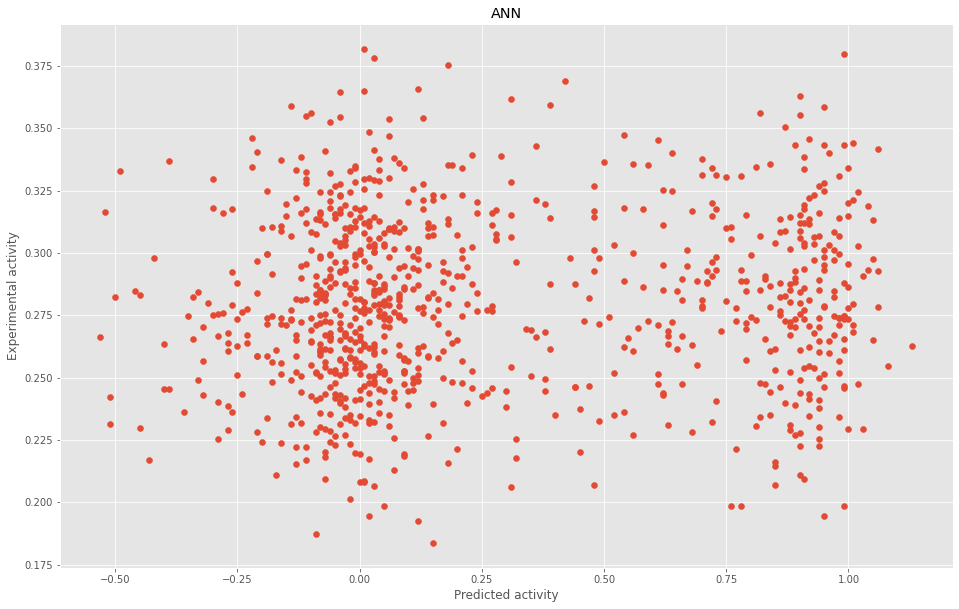

In [ ]:
plt.scatter(y_test, y_pred_nn_test)
plt.title('ANN')
plt.xlabel('Predicted activity')
plt.ylabel('Experimental activity')

The lack of a very high performance might lie behind the training of the latent space model. Indeed, our latent space model has been trained on a small dataset: 2748 sequences, compared to 31K in the publication [3]. The second hypothesis is that the training of the latent space model hasn't converged yet, so the hyperparameters (number of epochs and learning rate) should be better tuned. But we had better results (correlation of 0.3 for both the train and test set) with the same hyperparameters on a previous run, so different hyper-parametrization may lead again to a higer coefficient, or this might be due to luck since SVI is stochastic. Moreover, the clear star structure of the latent space representation of the sequences and the gradient of color in the branches suggest that the training has converged. 

Alternatively, the implementation of the ANN could also be improved. One could do some tunning on the hyperparameters for the ANN (number of layers and neurons for example). Another reason might be that the amount of data is too small for an ANN. The publication [3] achieves a Pearson correlation of 0.8 with a GP, which is better suited for small datasets compared to an ANN [4],  on a small dataset of 278 sequences and their corresponding experimental activities. 

## Design new sequences

This part will be focusing on the generation of new sequences with higher activity. 

To check that the latent space model works as expected, we will decode the latent space representation of the first sequence of the dataset using the trained latent space model, and compare it with the original sequence.

In [ ]:
x1 = list(train_data_loader)[0][0] # first sequence of the dataset
z1 = torch.tensor(z_loc[0]).cuda() # the corresponding latent space representation of this sequence

# decode the latent space representation of the first sequence using the trained latent space model
x1_pred = vae.backward(z1).cpu().data.numpy() # reconstructed sequence
x1 = x1.data.numpy()

print('Percentage of differing positions in the sequence vector', np.sum(x1_pred != x1)/2016*100)

Percentage of differing positions in the sequence vector 3.125


Only 3% of the reconstructed sequence vector is different from the original sequence, which means that the latent space model has correctly learned the latent space representation of the sequences in our dataset. 

Therefore, we can now engineer a new sequence by decoding the latent space representation z = [-3.15, -3.2] which we selected previously, and which we expect to have higher activity than the existing sequences. 

In [ ]:
z = torch.tensor([-3.15, -3.2]).cuda()  
x = vae.backward(z).cpu().data.numpy() # new sequence
x.shape

(2016,)

The following function converts a one-hot encoded sequence to a sequence of characters.

In [ ]:
# we'll inverse the dictionary, having the position as key and the letter as a value
inv_dic = {v:k for k, v in dic.items()}

def generate_seq(seq_encoded):
  seq_encoded = seq_encoded.reshape(L, 21)
  generated_seq = list(range(L))
  
  for idx_pos, positions in enumerate(seq_encoded):
    for idx_letter, pos_letter in enumerate(positions):
      if positions[idx_letter] == 1:
        generated_seq[idx_pos] = inv_dic[idx_letter]
    if generated_seq[idx_pos] == idx_pos:
      generated_seq[idx_pos] = '-'
  generated_seq = ''.join(str(e) for e in generated_seq)

  return generated_seq

Now, for test purposes, we shall print the newly generated amino acid sequence and its length.

In [ ]:
seq_letters_test = generate_seq(x)
print(seq_letters_test)
print(len(seq_letters_test))

D-CFMP-------YY-VCVETVS--A-----------NREMQYVWNT-QV-PH-NWVW---M----Q-EVY-W----Q---NDWV------T-EV-
96


It would also be interesting to see the first sequence of the dataset `x1` and its reconstruction `x1_pred`, and to compare their sequence of characters (amino acids). 

In [ ]:
x1_letters = generate_seq(x1)
x1_pred_letters = generate_seq(x1_pred)

print(x1_letters)
print(x1_pred_letters)

hamming_distance = np.sum(np.array(list(x1_pred_letters)) != np.array(list(x1_letters)))
print("number of differing positions", hamming_distance)

error_percentage = hamming_distance/L*100
print("error percentage", error_percentage)

---AYSHWV-----MYFQTVY-E---M--CI----IMEVIKRY-D-VPYTC----A---Q-M-----RLWYGDT-C-S--NV-WK-H-------V-
D--HYPHKV-----MYIQTVRDT-------S--W--MERIKRYKDGVNYTC---CA---Q-M---IGRMWYNYT---TAL-VKW--H----V--VS
number of differing positions 32
error percentage 33.33333333333333


The percentage of difference is much higher after we converted the binary sequence vector to a string of characters, because the binary reconstructed sequence might not correspond to a correct one-hot encoding, which means that one position in the sequence could be blank or correspond to multiple different characters. This problem should be tackled by changing the decoder, because the decoder samples the sequence from a Bernoulli distribution which doesn't take into account any constraint on the values of the sequence. The generative process should also be changed accordingly. 

# Conclusion

This section concludes the first technical report. We have learned how to fit a VAE for amino acid sequences, aiming at predicting enzymes activity based on sequences inferred into a latent space. Here, we have used both Linear Regression and a Neural Network.

Then, we went backwards, engineering new sequences from latent space values that depict high enzyme activity values.

Overall, we have learned that Bayesian Neural Nets can be quiet powerful, beating the KNN baseline in terms of RSNE, but still need a lot of hyper-parametrization techniques and large amounts of data, as it performed slightly better than the Linear Regression on the test set, yet slightly below it for the training data.